# Technical appendix - NumericAnalysis

## A. Objectives & scope

* **Goal:** rigorous **numeric-only EDA** for tabular datasets: distributional diagnostics, transformations, outlier policy, dependence structure, multicollinearity pruning, and feature selection—readying inputs for downstream modelling.
* **Inputs:** a wide numeric matrix (rows = observations, columns = numeric features) with optional metadata (units, domains). Non-numeric columns are dropped or separately encoded upstream.

## B. Data contract & validation

* **Required:** at least one numeric column; rows with all-NA in numeric columns are removed.
* **Constraints:** finite values only; NA rate per column ≤ threshold; constant/near-constant features flagged.
* **Schema:** `schemas.py` enforces numeric dtypes, uniqueness of index if provided, and optional min/max per feature.

## C. Descriptive profiling (`profiling.py`)

* Per-feature: count, %NA, mean/median, std/MAD, min/max, IQR, **skewness/kurtosis**, CoV.
* Normality tests: **Anderson–Darling**, **Kolmogorov–Smirnov** (with parameter-fitting cautions).
* Distributional views: hist/KDE, ECDF, QQ plots; heavy-tail flags via tail index heuristics.
* Export: `descriptives.csv`, `normality.csv`.

## D. Transformations (`transforms.py`)

* **Stabilize variance:** Box–Cox (x>0) / Yeo–Johnson (any x); store λ for invertibility.
* **Scaling:** Standard/MinMax/Robust; per-feature pipelines based on `transforms.yaml`.
* **Winsorization/clipping:** quantile-based; record clipped counts.
* **Idempotence:** ensure repeated transforms are no-ops; metadata saved in `artefacts/`.

## E. Outlier detection (`outliers.py`)

* **Univariate:** IQR rule, Z-score, robust Z (MAD), Generalized ESD, Hampel filter.
* **Labeling:** boolean masks + reason codes; per-feature thresholds configurable.
* **Policy:** report-only vs. cap/winsorize vs. drop; actions logged with counts and sample IDs (hashed).

## F. Dependence analysis (`correlation.py`)

* **Linear & rank:** Pearson/Spearman/Kendall with pairwise-complete obs.
* **Nonlinear:** distance correlation and **mutual information** (kNN estimator or binned).
* **Multiple testing:** Benjamini–Hochberg FDR across pairwise hypotheses.
* Artefacts: `corr_pearson.csv`, `corr_spearman.csv`, `corr_kendall.csv`, `dist_corr.csv`, `mi.csv`, `p_adj.csv`.

## G. Multicollinearity (`multicollinearity.py`)

* **VIF** computation on standardized features; drop rule if `VIF > τ` (from config).
* **Condition number** of X; warn if ill-conditioned.
* **Correlation-threshold pruning:** hierarchical clustering + representative feature selection.
* Export: `vif.csv`, `pruned_features.csv`, `condition_number.json`.

## H. Feature selection (`selection.py`)

* **Filter:** univariate MI/ANOVA F for continuous targets (optional if a target is provided).
* **Embedded:** Lasso/Ridge coefficients ranking; stability via bootstrapping (optional).
* **Wrapper:** RFE with linear or tree models (fast defaults).
* Output: `selected_features.csv` with method, rank, and rationale.

## I. Dimensionality reduction (`dimensionality.py`)

* **PCA/FA:** explained variance, loadings, component scores; rotation (varimax) for FA.
* **Diagnostics:** Kaiser–Meyer–Olkin (KMO) and Bartlett’s test (if enabled).
* Artefacts: `pca_loadings.csv`, `pca_scores.parquet`, scree & biplot figures.

## J. Diagnostics (`diagnostics.py`)

* **Heteroskedasticity:** Breusch–Pagan / White tests on simple linear fits (if target exists).
* **Influence:** leverage and Cook’s distance summaries (optional).
* **Missingness structure:** MCAR proxy via permutation tests on means/variances.

## K. Visualization (`plotting.py`)

* Consistent theme via `set_theme()`.
* Plots: hist/KDE, ECDF, box/violin, QQ, correlation heatmaps (with significance masks), pairwise scatter for top-K correlated pairs, PCA scree/biplot.
* Saved to `reports/figures/` as `.png` (2× DPI) and optional `.svg`.

## L. Reporting (`reporting.py`)

* Builds `reports/report.html` with:

  * Executive summary (N rows/cols, %NA, #outliers handled).
  * Distributional diagnostics & transformations applied.
  * Dependence map highlights + multicollinearity actions taken.
  * Selected features and/or PCA summary.
  * Reproducibility metadata (config fingerprint, git SHA, versions).

## M. CLI workflow

* **Prep:** `python -m numeric_eda.cli.prep --config configs/data.yaml --quality configs/quality.yaml`
* **Analyze:** `python -m numeric_eda.cli.analyze --transforms configs/transforms.yaml --outliers configs/outliers.yaml --corr configs/correlation.yaml`
* **Select:** `python -m numeric_eda.cli.select --multicol configs/multicollinearity.yaml --selection configs/selection.yaml --pca configs/pca.yaml`
* **Report:** `python -m numeric_eda.cli.report --reporting configs/reporting.yaml --out reports/report.html`

## N. Testing strategy

* Synthetic fixtures: Gaussian, heavy-tail (tν), skewed (log-normal), mixtures.
* Outlier inject tests: recovery rates for IQR/Z/MAD/ESD/Hampel.
* Correlation/MI invariants and FDR correctness.
* VIF pruning determinism with fixed seeds; PCA orthogonality/variance checks.
* Plot smoke tests to verify artefacts exist and are non-empty.

## O. Reproducibility & ops

* `seed_everywhere(seed)` for Python/NumPy/sklearn.
* Dependencies pinned; nbstripout for notebooks; structured logs include dataset shape and timings.
* CI: ruff+black+pytest; on tags, publish `reports/` and `artefacts/`.

## P. Migration from the notebook

* Map notebook sections to modules:

  * Descriptive stats/plots → `profiling.py`, `plotting.py`
  * Outlier logic → `outliers.py`
  * Correlation/MI → `correlation.py`
  * VIF/pruning → `multicollinearity.py`
  * Feature selection/PCA → `selection.py`, `dimensionality.py`
  * Narrative assembly → `reporting.py`
* Replace globals with YAML-driven configs; keep the notebook for exploratory work with `nbstripout` enabled.

---

If you want, I can scaffold `outliers.py`, `multicollinearity.py`, and `selection.py` with ready-to-run functions and CLI entrypoints based on this layout.


In [ ]:
# ===========================
# Project Structure
# ===========================

# numeric-analysis-eda/
# ├── pyproject.toml                     # Build + pinned deps (poetry/pip-tools). Python ≥3.10
# ├── README.md                          # Overview, assumptions, quickstart
# ├── .env.example                       # Runtime toggles (plot DPI, cache flags)
# ├── .gitignore                         # Ignore data/artefacts/logs, *.ipynb_checkpoints
# ├── .pre-commit-config.yaml            # Ruff, Black, isort, nbstripout hooks
# ├── Makefile                           # make setup|prep|profile|analyze|select|report|test
# ├── configs/                           # Declarative YAML/TOML configs
# │   ├── data.yaml                      # Input paths, numeric column list/regex, date parsing
# │   ├── quality.yaml                   # Missingness thresholds, constant/near-constant limits
# │   ├── transforms.yaml                # Scaling, Box-Cox/YJ, winsorization, clipping policy
# │   ├── outliers.yaml                  # IQR/Z/MAD params, ESD/Hampel toggles
# │   ├── correlation.yaml               # Pearson/Spearman/Kendall, MI params, FDR alpha
# │   ├── multicollinearity.yaml         # VIF threshold, condition number, drop rules
# │   ├── selection.yaml                 # Feature selection (filter, MI, RFE/Ridge/Lasso)
# │   ├── pca.yaml                       # PCA/FA settings, scaling, n_components, rotation
# │   ├── tests.yaml                     # Synthetic data seeds, tolerances
# │   └── reporting.yaml                 # Figure toggles, DPI, table limits, theme
# ├── data/                              # Data Lake-style layout (read-only except interim)
# │   ├── raw/                           # Immutable extracts (CSV/Parquet) + checksums
# │   ├── interim/                       # Cleaned/typed/validated tables
# │   └── processed/                     # Analysis-ready numeric matrix (wide) + metadata
# ├── notebooks/
# │   └── EDA - NumericAnalysis.ipynb    # (uploaded) numeric EDA: profiling→transforms→selection
# ├── src/
# │   └── numeric_eda/
# │       ├── __init__.py                # Version, public API
# │       ├── logging.py                 # Structured logging (JSON) + rich console
# │       ├── io.py                      # Robust CSV/Parquet IO; dtype coercion; schema locks
# │       ├── schemas.py                 # Pandera/pyarrow schemas for numeric matrices/metadata
# │       ├── utils.py                   # seed_everywhere, timer, memory guard, dataframe ops
# │       ├── quality.py                 # Missingness, constant/near-constant, finite checks
# │       ├── profiling.py               # Descriptives, moments, normality (AD/KS), QQ
# │       ├── transforms.py              # Box-Cox/YJ, standardize/robust-scale, winsorize/clip
# │       ├── outliers.py                # IQR, Z/MAD, ESD, Hampel; reason codes & masks
# │       ├── correlation.py             # Pearson/Spearman/Kendall, distance corr, MI (kNN/bins)
# │       ├── multicollinearity.py       # VIF, condition number, correlation-threshold pruning
# │       ├── selection.py               # Filter + wrapper (MI, RFE), embedded (Lasso/Ridge)
# │       ├── dimensionality.py          # PCA/FA, explained variance, loadings, scores
# │       ├── diagnostics.py             # Heteroskedasticity (BP/White), normality, leverage
# │       ├── anomalies.py               # Univariate + multivariate (RobustCov/Mahalanobis)
# │       ├── plotting.py                # Theme + hist/KDE, ECDF, box/violin, pairwise heatmaps
# │       ├── reporting.py               # Build HTML/PDF report; assemble figs & tables
# │       └── cli/                       # Typer CLIs
# │           ├── prep.py                # Clean/validate → data/interim + processed
# │           ├── analyze.py             # Run profiling/transforms/outliers/correlation suite
# │           ├── select.py              # Run multicollinearity pruning + feature selection
# │           └── report.py              # Compile report.html from artefacts
# ├── scripts/
# │   ├── export_summary.py              # Per-feature summary → reports/tables/summary.csv
# │   ├── export_corr.py                 # Correlation/MI matrices → CSV/Parquet
# │   └── export_selected_features.py    # Final selected feature set → CSV
# ├── reports/
# │   ├── figures/                       # Hist/KDE, QQ, ECDF, box, corr heatmaps, PCA scree/biplot
# │   ├── tables/                        # descriptives.csv, normality.csv, outliers.csv, corr*.csv
# │   └── report.html                    # Single-file HTML report
# ├── artefacts/                         # metadata.json (config hash, git SHA, runtimes)
# ├── tests/                             # Pytest suite (fast, deterministic)
# │   ├── test_quality.py                # Missingness/constant-col detection
# │   ├── test_transforms.py             # Box-Cox/YJ invertibility; scaling idempotence
# │   ├── test_outliers.py               # IQR/Z/MAD/ESD/Hampel correctness on synthetic data
# │   ├── test_correlation.py            # Corr/MI invariants; FDR monotonicity
# │   ├── test_multicollinearity.py      # VIF pruning behavior; condition-number bounds
# │   ├── test_selection.py              # MI/RFE/Lasso ranking stability on seeded sims
# │   ├── test_dimensionality.py         # PCA variance ratios & loading orthogonality
# │   └── test_plotting.py               # Figure smoke tests (non-empty files)
# └── ci/
#     └── pipeline.yaml                  # Lint→Test→Build; cache deps; publish artefacts


In [1]:
# ===========================
# Multi-Year SERL Dashboard
# ===========================
from __future__ import annotations
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown

# ---------- Color scheme (FIXED: strings, no commas) ----------
PRIMARY_COLOR   = "#12436D" # deep blue
SECONDARY_COLOR = "#821952"  # plum
ACCENT_COLOR    = "#F18F01"  # golden yellow
LIGHT_BG        = "#F5F5F5"  # light gray background
DARK_TEXT       = "#333333"  # dark text

# A professional–feminine plotting palette (10 colors)
PALETTE = [
    PRIMARY_COLOR, SECONDARY_COLOR, ACCENT_COLOR, "#F4A259",
    "#8E6E95", "#7FB3D5", "#D98880", "#F9E79F", "#A9CCE3", "#C39BD3"
]

# ---------- Matplotlib look ----------
plt.rcParams.update({
    "figure.figsize": (10, 6),
    "figure.dpi": 120,
    "figure.facecolor": "#ffffff",
    "axes.facecolor": "#ffffff",
    "axes.edgecolor": "#222222",
    "grid.color": "#e5e5ef",
    "grid.alpha": 0.85,
    "axes.grid": True,
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.titleweight": "bold",
    "axes.labelcolor": DARK_TEXT,
    "text.color": DARK_TEXT,
    "legend.frameon": False,
})
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=PALETTE)
plt.rcParams.update({'font.family':'serif','font.serif':['Times New Roman','Times','serif']})

# ---------- Helpers ----------
def _to_num(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce")

def _fmt(x, digits=3):
    if pd.isna(x): return "NaN"
    if isinstance(x, (int, np.integer)): return f"{x:,}"
    x = float(x)
    if abs(x) >= 10000: return f"{x:,.0f}"
    if abs(x) >= 1000:  return f"{x:.{max(0, digits-1)}f}"
    if abs(x) >= 1:     return f"{x:.{digits}f}"
    return f"{x:.{digits+1}g}"

def prepare_frame(df: pd.DataFrame, year: int) -> pd.DataFrame:
    out = df.copy()
    # Ensure key numerics are numeric
    for c in ["mean","standard_deviation","standard_error_mean","median",
              "25th_percentile","75th_percentile","mean_temp","mean_solar","n_rounded"]:
        if c in out.columns:
            out[c] = pd.to_numeric(out[c], errors="coerce")
    # Half-hour index from summary_time if available
    if "halfhour_index" not in out.columns and "summary_time" in out.columns:
        t = pd.to_datetime(out["summary_time"], format="%H:%M", errors="coerce")
        out["hour"] = t.dt.hour
        out["minute"] = t.dt.minute
        out["halfhour_index"] = ((out["hour"] * 60 + out["minute"]) // 30).clip(0, 47)
    # Year columns
    if "aggregation_period" not in out.columns:
        out["aggregation_period"] = int(year)
    out["year"] = out["aggregation_period"].astype(int)
    return out

def add_all_metrics(df: pd.DataFrame, m0: float = 0.0) -> pd.DataFrame:
    out = df.copy()
    mean = _to_num(out.get("mean"))
    sd   = _to_num(out.get("standard_deviation"))
    sem  = _to_num(out.get("standard_error_mean"))
    med  = _to_num(out.get("median"))
    q1   = _to_num(out.get("25th_percentile"))
    q3   = _to_num(out.get("75th_percentile"))
    n    = _to_num(out.get("n_rounded"))
    unit = out.get("unit", pd.Series(index=out.index, dtype=object)).astype(str).str.lower()

    out["variance"]       = sd**2
    out["cv"]             = sd / mean
    out["iqr"]            = q3 - q1
    out["qcd"]            = (q3 - q1) / (q3 + q1)
    out["midhinge"]       = (q1 + q3) / 2
    out["trimean"]        = (q1 + 2*med + q3) / 4
    out["pearson_skew"]   = 3*(mean - med) / sd
    out["bowley_skew"]    = (q3 + q1 - 2*med) / (q3 - q1)
    out["ci95_lo"]        = mean - 1.96*sem
    out["ci95_hi"]        = mean + 1.96*sem

    out["n_est_from_sem"] = (sd / sem)**2
    out["t_stat_m0"]      = (mean - m0) / (sd / np.sqrt(n))

    out["tukey_lo"]       = q1 - 1.5*(q3 - q1)
    out["tukey_hi"]       = q3 + 1.5*(q3 - q1)

    out["mean_kwh"]       = np.where(unit.eq("wh"), mean/1000.0, mean)
    out["total_mean_for_sample"] = mean * n

    # Weather features (if present)
    if "mean_temp" in out.columns:
        out["HDH_18"] = np.clip(18 - out["mean_temp"], 0, None)
        out["CDH_22"] = np.clip(out["mean_temp"] - 22, 0, None)
    if "mean_solar" in out.columns:
        out["solar_norm01"] = (out["mean_solar"] - out["mean_solar"].min()) / (
            out["mean_solar"].max() - out["mean_solar"].min() + 1e-12
        )

    out.replace([np.inf, -np.inf], np.nan, inplace=True)
    return out

# ---------- Pretty math card (colors fixed) ----------
def show_math_card(row: pd.Series, m0: float = 0.0):
    def _safe(x): return pd.to_numeric(x, errors="coerce")
    mean = _safe(row.get("mean"))
    sd   = _safe(row.get("standard_deviation"))
    sem  = _safe(row.get("standard_error_mean"))
    med  = _safe(row.get("median"))
    q1   = _safe(row.get("25th_percentile"))
    q3   = _safe(row.get("75th_percentile"))
    n_in = _safe(row.get("n_rounded"))
    unit = str(row.get("unit", "")).lower()

    n_eff  = n_in if (pd.notna(n_in) and n_in > 0) else ((sd/sem)**2 if (pd.notna(sd) and pd.notna(sem) and sem>0) else np.nan)
    t_val  = (mean - float(m0)) / (sd / np.sqrt(n_eff)) if (pd.notna(mean) and pd.notna(sd) and pd.notna(n_eff) and n_eff>0 and sd>0) else np.nan

    variance = sd**2 if pd.notna(sd) else np.nan
    cv       = sd/mean if (pd.notna(sd) and pd.notna(mean) and mean!=0) else np.nan
    iqr      = q3-q1 if (pd.notna(q3) and pd.notna(q1)) else np.nan
    qcd      = (q3-q1)/(q3+q1) if (pd.notna(q3) and pd.notna(q1) and (q3+q1)!=0) else np.nan
    midhinge = (q1+q3)/2 if (pd.notna(q1) and pd.notna(q3)) else np.nan
    trimean  = (q1+2*med+q3)/4 if all(pd.notna(v) for v in [q1,med,q3]) else np.nan
    p_skew   = (3*(mean-med)/sd) if all(pd.notna(v) for v in [mean,med,sd]) and sd!=0 else np.nan
    b_skew   = ((q3+q1-2*med)/(q3-q1)) if all(pd.notna(v) for v in [q3,q1,med]) and (q3-q1)!=0 else np.nan
    ci_lo    = mean - 1.96*sem if all(pd.notna(v) for v in [mean,sem]) else np.nan
    ci_hi    = mean + 1.96*sem if all(pd.notna(v) for v in [mean,sem]) else np.nan
    n_est    = (sd/sem)**2 if all(pd.notna(v) for v in [sd,sem]) and sem>0 else np.nan
    tuk_lo   = q1 - 1.5*iqr if pd.notna(iqr) and pd.notna(q1) else np.nan
    tuk_hi   = q3 + 1.5*iqr if pd.notna(iqr) and pd.notna(q3) else np.nan
    mean_kwh = mean/1000.0 if (unit=="wh" and pd.notna(mean)) else mean
    total_m  = mean * n_in if all(pd.notna(v) for v in [mean,n_in]) else np.nan

    css = f"""
    <style>
      .math-card {{
        border: 2px solid {PRIMARY_COLOR};
        border-radius: 12px;
        padding: 20px;
        margin: 15px 0;
        background: white;
        font-family: 'Helvetica Neue', Arial, sans-serif;
        box-shadow: 0 4px 8px rgba(0,0,0,0.08);
      }}
      .math-header {{
        color: {DARK_TEXT};
        margin: 0 0 15px 0;
        font-size: 22px;
        font-weight: 700;
        border-bottom: 2px solid {ACCENT_COLOR};
        padding-bottom: 10px;
        font-family: 'Times New Roman', serif;
      }}
      .badge {{
        display: inline-block;
        padding: 4px 10px;
        border-radius: 16px;
        background: {SECONDARY_COLOR};
        color: white;
        font-size: 13px;
        margin-left: 8px;
        font-weight: 600;
      }}
      .math-grid {{ display: grid; grid-template-columns: 1fr 1fr; gap: 20px; }}
      @media (max-width: 900px) {{ .math-grid {{ grid-template-columns: 1fr; }} }}
      .math-section h3 {{ color: {PRIMARY_COLOR}; margin: 0 0 10px 0; font-size: 18px; font-weight: 700; }}
      table.kv {{ width: 100%; border-collapse: collapse; font-size: 14px; }}
      table.kv th, table.kv td {{ padding: 8px 12px; border-bottom: 1px solid #e9e9e9; text-align: left; }}
      table.kv th {{ width: 60%; color: {DARK_TEXT}; background: {LIGHT_BG}; }}
      .formula-container {{ background: {LIGHT_BG}; border-radius: 8px; padding: 12px 14px; margin: 10px 0; }}
      .formula-title {{ color: {SECONDARY_COLOR}; font-weight: 700; margin-bottom: 6px; }}
      .formula-result {{ font-weight: 700; color: {PRIMARY_COLOR}; margin-top: 4px; display: inline-block; }}
    </style>
    """

    summary_stats = f"""
    <div class="math-section">
      <h3>Summary Statistics</h3>
      <table class="kv">
        <tr><th>Mean</th><td>{_fmt(mean)}</td></tr>
        <tr><th>Std. Deviation</th><td>{_fmt(sd)}</td></tr>
        <tr><th>Std. Error (SEM)</th><td>{_fmt(sem)}</td></tr>
        <tr><th>Median</th><td>{_fmt(med)}</td></tr>
        <tr><th>Q1 (25%)</th><td>{_fmt(q1)}</td></tr>
        <tr><th>Q3 (75%)</th><td>{_fmt(q3)}</td></tr>
        <tr><th>n</th><td>{_fmt(n_in,0)}</td></tr>
      </table>
    </div>
    """

    derived = f"""
    <div class="math-section">
      <h3>Derived Metrics</h3>
      <table class="kv">
        <tr><th>Variance (s²)</th><td>{_fmt(variance)}</td></tr>
        <tr><th>Coeff. of Variation (CV)</th><td>{_fmt(cv)}</td></tr>
        <tr><th>IQR</th><td>{_fmt(iqr)}</td></tr>
        <tr><th>QCD</th><td>{_fmt(qcd)}</td></tr>
        <tr><th>Midhinge</th><td>{_fmt(midhinge)}</td></tr>
        <tr><th>Trimean</th><td>{_fmt(trimean)}</td></tr>
        <tr><th>Pearson skew</th><td>{_fmt(p_skew)}</td></tr>
        <tr><th>Bowley skew</th><td>{_fmt(b_skew)}</td></tr>
        <tr><th>95% CI</th><td>[{_fmt(ci_lo)}, {_fmt(ci_hi)}]</td></tr>
        <tr><th>n̂ (from s/SEM)</th><td>{_fmt(n_est,0)}</td></tr>
        <tr><th>t (vs m₀={_fmt(m0)})</th><td>{_fmt(t_val)}</td></tr>
        <tr><th>Tukey fences</th><td>[{_fmt(tuk_lo)}, {_fmt(tuk_hi)}]</td></tr>
        <tr><th>mean (kWh)</th><td>{_fmt(mean_kwh)}</td></tr>
        <tr><th>sample total ≈ x̄·n</th><td>{_fmt(total_m)}</td></tr>
      </table>
    </div>
    """

    html = f"""
    {css}
    <div class="math-card">
      <h2 class="math-header">Statistical Analysis <span class="badge">Row {row.name if hasattr(row,'name') else 'N/A'}</span></h2>
      <div class="math-grid">
        {summary_stats}
        {derived}
      </div>
    </div>
    """
    display(HTML(html))

# ---------- Multi-year plots ----------
def multi_year_dashboard(dfs: dict[int, pd.DataFrame], m0: float = 0.0, energy_col: str = "mean"):
    # Header + style (Times New Roman, black headings)
    display(HTML(f"""
    <style>
      h1,h2,h3 {{ font-family:'Times New Roman', Times, serif; color:#000; }}
      .pill {{ display:inline-block; padding:4px 10px; border-radius:14px; 
               background:{LIGHT_BG}; border:1px solid {PRIMARY_COLOR}; color:{DARK_TEXT}; }}
    </style>
    <h1 style="text-align:center; margin-bottom:4px;">SERL Multi-Year Dashboard</h1>
    <div style="text-align:center; margin-bottom:16px;">
      <span class="pill">Palette: Deep Blue / Plum / Gold</span>
    </div>
    """))

    # Prepare + derive per year, then concat
    frames = []
    for year, df in sorted(dfs.items()):
        f = prepare_frame(df, year)
        f = add_all_metrics(f, m0=m0)
        frames.append(f)
    ALL = pd.concat(frames, ignore_index=True)

    # ---- Overview: records per year & quantity share ----
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    counts = ALL["year"].value_counts().sort_index()
    axes[0].bar(counts.index.astype(int), counts.values)
    axes[0].set_title("Records by Year")
    axes[0].set_xlabel("Year"); axes[0].set_ylabel("Count")

    if "quantity" in ALL.columns:
        qshare = ALL["quantity"].value_counts().head(8)
        axes[1].pie(qshare.values, labels=qshare.index, autopct="%1.1f%%", startangle=90)
        axes[1].set_title("Top Quantities (share)")
    plt.tight_layout(); plt.show()

    # ---- Yearly trend (mean ± SD band of row means) ----
    yr = ALL.groupby("year")[energy_col]
    m = yr.mean(); s = yr.std()
    plt.figure(figsize=(10,5))
    x = m.index.astype(int)
    plt.plot(x, m.values, marker="o", linewidth=2, label="Mean")
    if len(s) == len(m):
        plt.fill_between(x, (m-s).values, (m+s).values, alpha=0.2, label="±1 SD")
    plt.title(f"Yearly Trend of {energy_col}")
    plt.xlabel("Year"); plt.ylabel(energy_col); plt.legend()
    plt.tight_layout(); plt.show()

    # ---- CV by year (median CV across rows) ----
    cv_year = ALL.groupby("year")["cv"].median()
    plt.figure(figsize=(10,5))
    plt.plot(cv_year.index.astype(int), cv_year.values, marker="o")
    plt.title("Median Coefficient of Variation by Year")
    plt.xlabel("Year"); plt.ylabel("CV (median)")
    plt.tight_layout(); plt.show()

    # ---- Mean with 95% CI by year (row-wise CI averaged; simple visual) ----
    ci = ALL.groupby("year")[["ci95_lo","ci95_hi",energy_col]].mean()
    x = ci.index.astype(int)
    y = ci[energy_col].values
    yerr = np.vstack([y - ci["ci95_lo"].values, ci["ci95_hi"].values - y])
    plt.figure(figsize=(10,5))
    plt.errorbar(x, y, yerr=yerr, fmt="o", capsize=5, lw=1.6)
    plt.title(f"{energy_col} with (approx) 95% CI by Year")
    plt.xlabel("Year"); plt.ylabel(energy_col)
    plt.tight_layout(); plt.show()

    # ---- Half-hour profiles per year (if available) ----
    if "halfhour_index" in ALL.columns:
        prof = ALL.groupby(["year","halfhour_index"])[energy_col].mean().unstack(0).sort_index()
        plt.figure(figsize=(12,6))
        for i, col in enumerate(prof.columns):
            plt.plot(prof.index, prof[col], label=str(col), linewidth=2)
        ticks = np.arange(0, 48, 4)
        plt.xticks(ticks, [f"{int(t/2):02d}:00" for t in ticks], rotation=0)
        plt.title(f"Average Daily Profile by Year — {energy_col}")
        plt.xlabel("Half-hour"); plt.ylabel(energy_col); plt.legend(title="Year")
        plt.tight_layout(); plt.show()

    # ---- Top quantities across years ----
    if "quantity" in ALL.columns:
        top_q = ALL.groupby("quantity")[energy_col].mean().nlargest(5).index
        g = ALL[ALL["quantity"].isin(top_q)].groupby(["year","quantity"])[energy_col].mean().unstack("quantity")
        plt.figure(figsize=(12,6))
        for col in g.columns:
            plt.plot(g.index.astype(int), g[col].values, marker="o", linewidth=2, label=str(col))
        plt.title(f"Top Quantities — Mean {energy_col} by Year")
        plt.xlabel("Year"); plt.ylabel(energy_col); plt.legend()
        plt.tight_layout(); plt.show()

    # ---- t-statistics vs m0 by year ----
    fig, axes = plt.subplots(2, 2, figsize=(14, 9))
    axes = axes.ravel()
    for ax, year in zip(axes, sorted(dfs.keys())):
        tvals = ALL.loc[ALL["year"]==year, "t_stat_m0"].dropna()
        ax.hist(tvals, bins=40)
        ax.axvline(0, color="#444", lw=1)
        ax.set_title(f"t-statistics (year {year})")
        ax.set_xlabel("t"); ax.set_ylabel("freq")
    plt.tight_layout(); plt.show()

    # ---- Compact preview table ----
    keep_cols = [
        "year","quantity","unit","summary_time","mean","standard_deviation","standard_error_mean","median",
        "25th_percentile","75th_percentile","n_rounded","variance","cv","iqr","qcd","midhinge","trimean",
        "pearson_skew","bowley_skew","ci95_lo","ci95_hi","n_est_from_sem","t_stat_m0","tukey_lo","tukey_hi",
        "mean_kwh","total_mean_for_sample","HDH_18","CDH_22","solar_norm01"
    ]
    present = [c for c in keep_cols if c in ALL.columns]
    display(Markdown("### Preview of Derived Metrics (first 50 rows)"))
    display(ALL[present].head(50))

    display(Markdown("_End of multi-year dashboard._"))
    return ALL  # so you can keep using it


In [2]:
df_2020= pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2020_aggregated_statistics.csv")
df_2021= pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2021_aggregated_statistics.csv")
df_2022= pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2022_aggregated_statistics.csv")
df_2023= pd.read_csv("/Users/akanksha/Downloads/ERP_DSM_Dissertation_2025/data/csv/serl_half_hourly_energy_use_in_gb_domestic_buildings_2023_aggregated_statistics.csv")

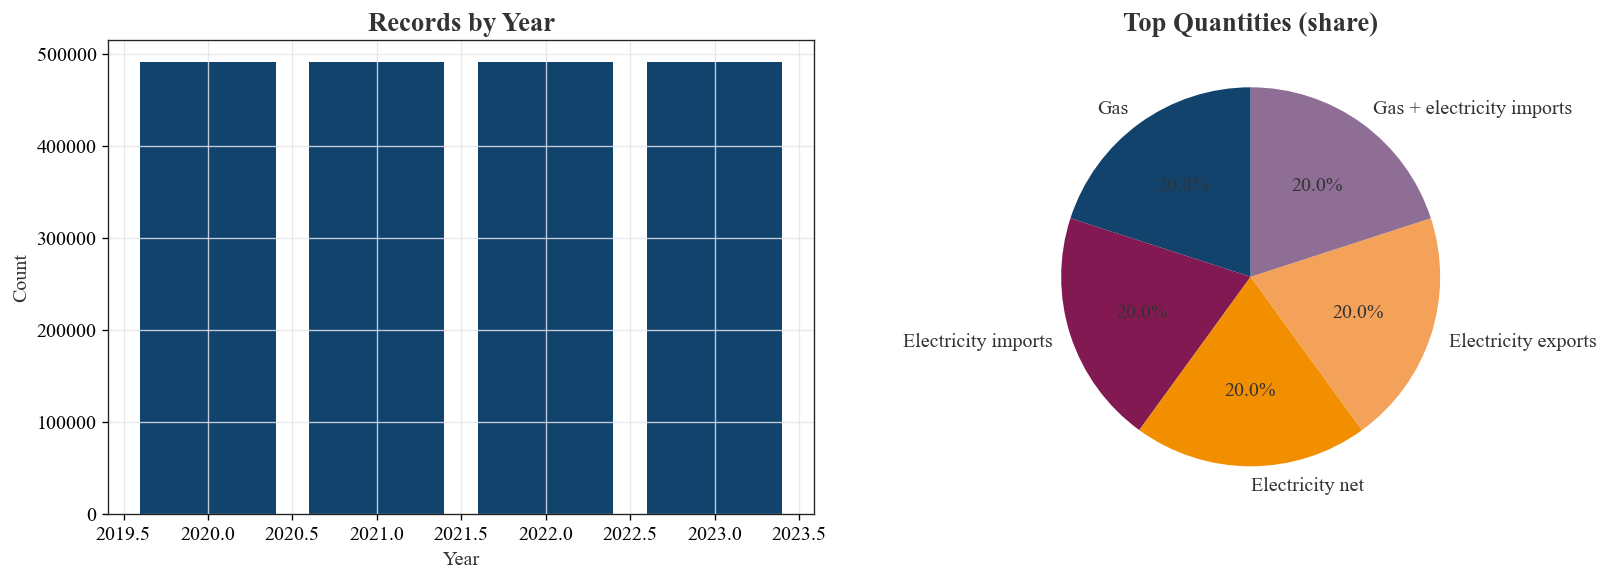

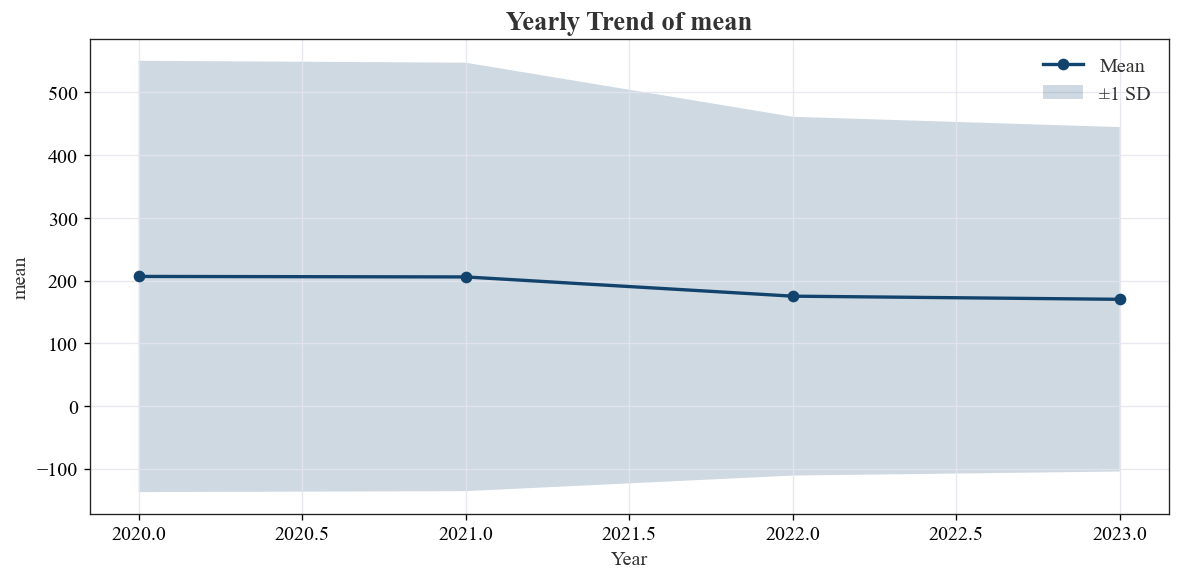

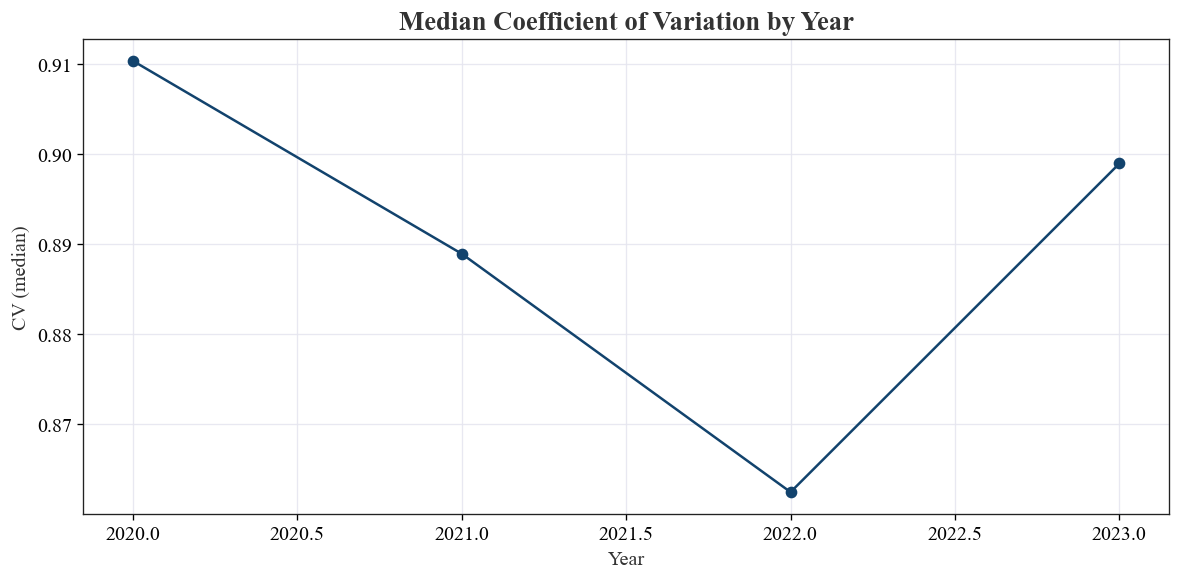

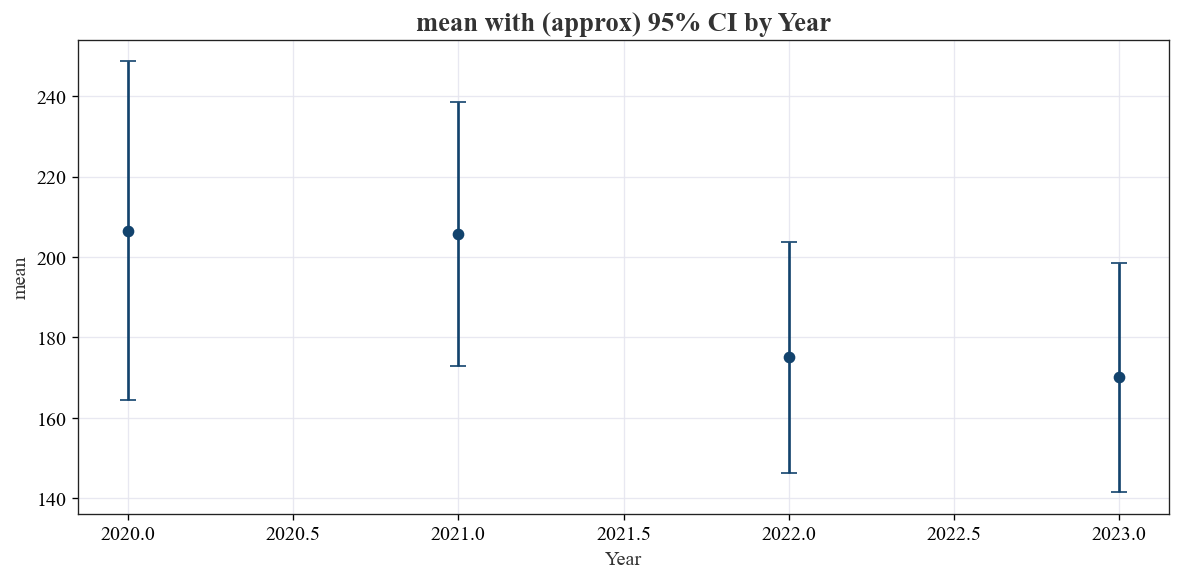

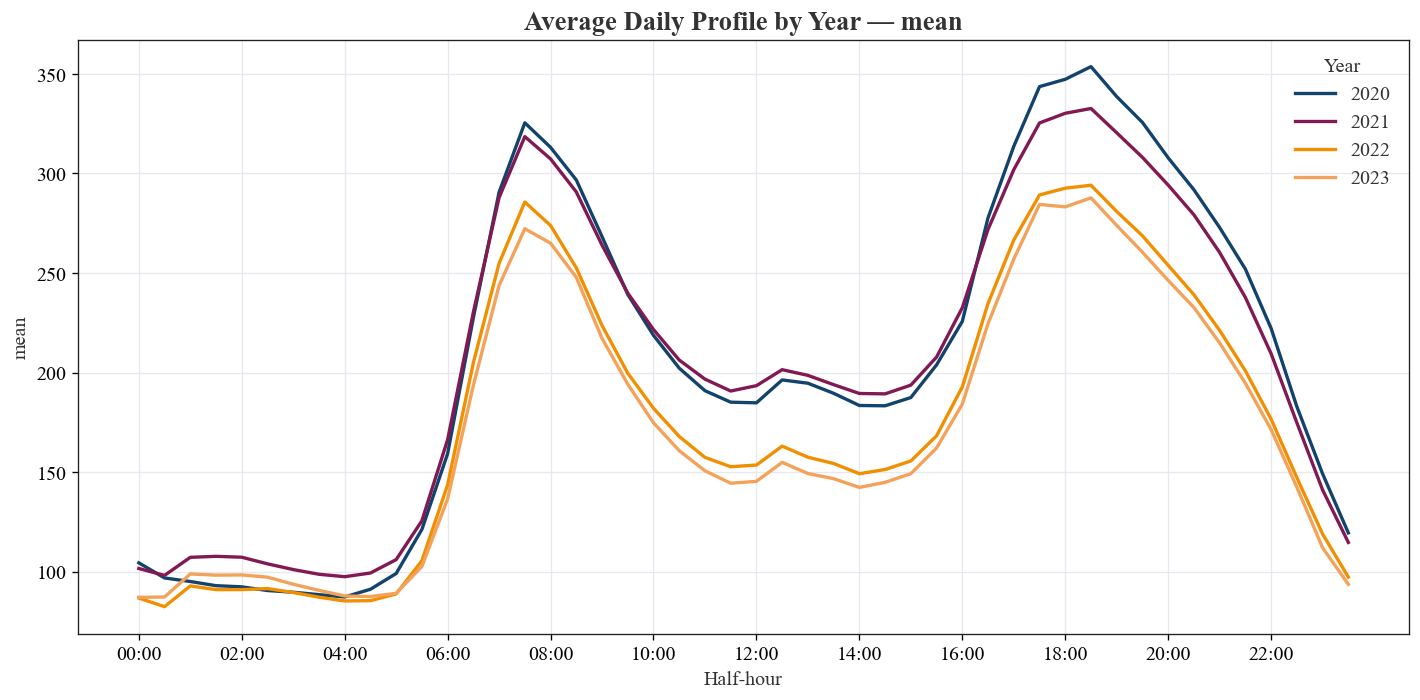

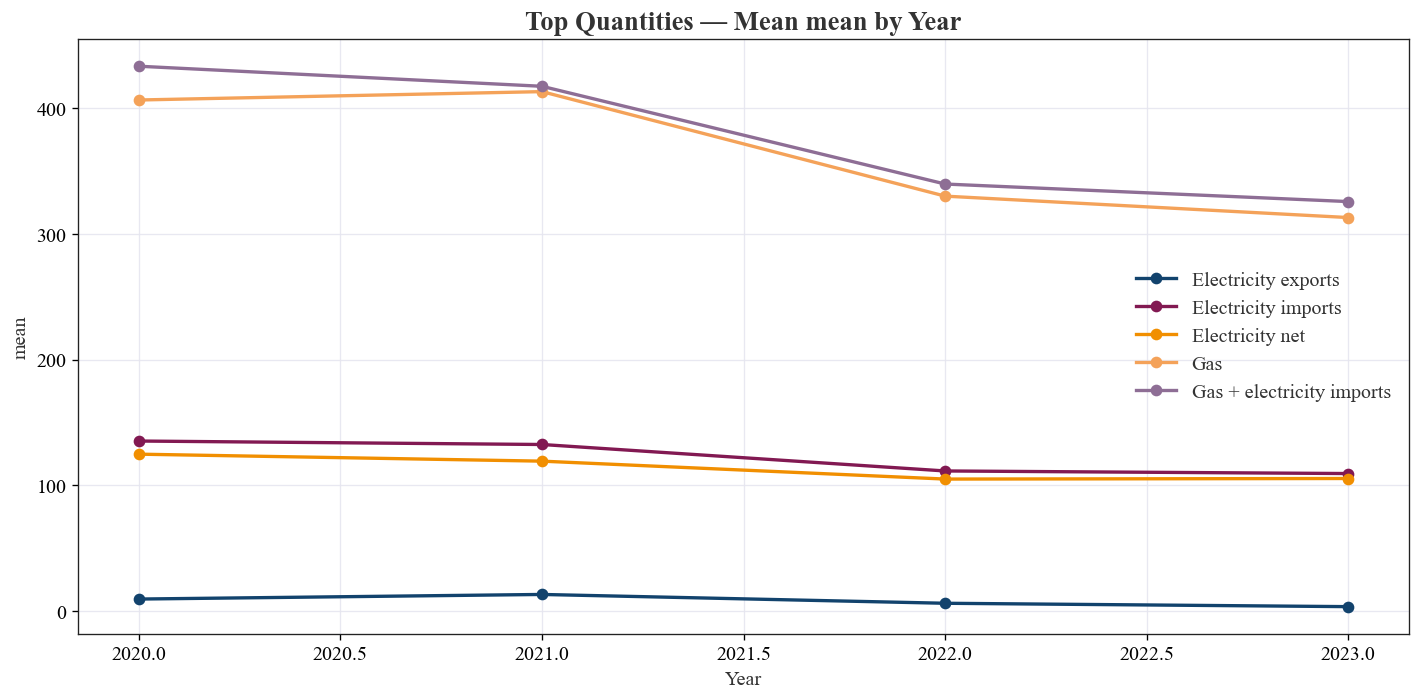

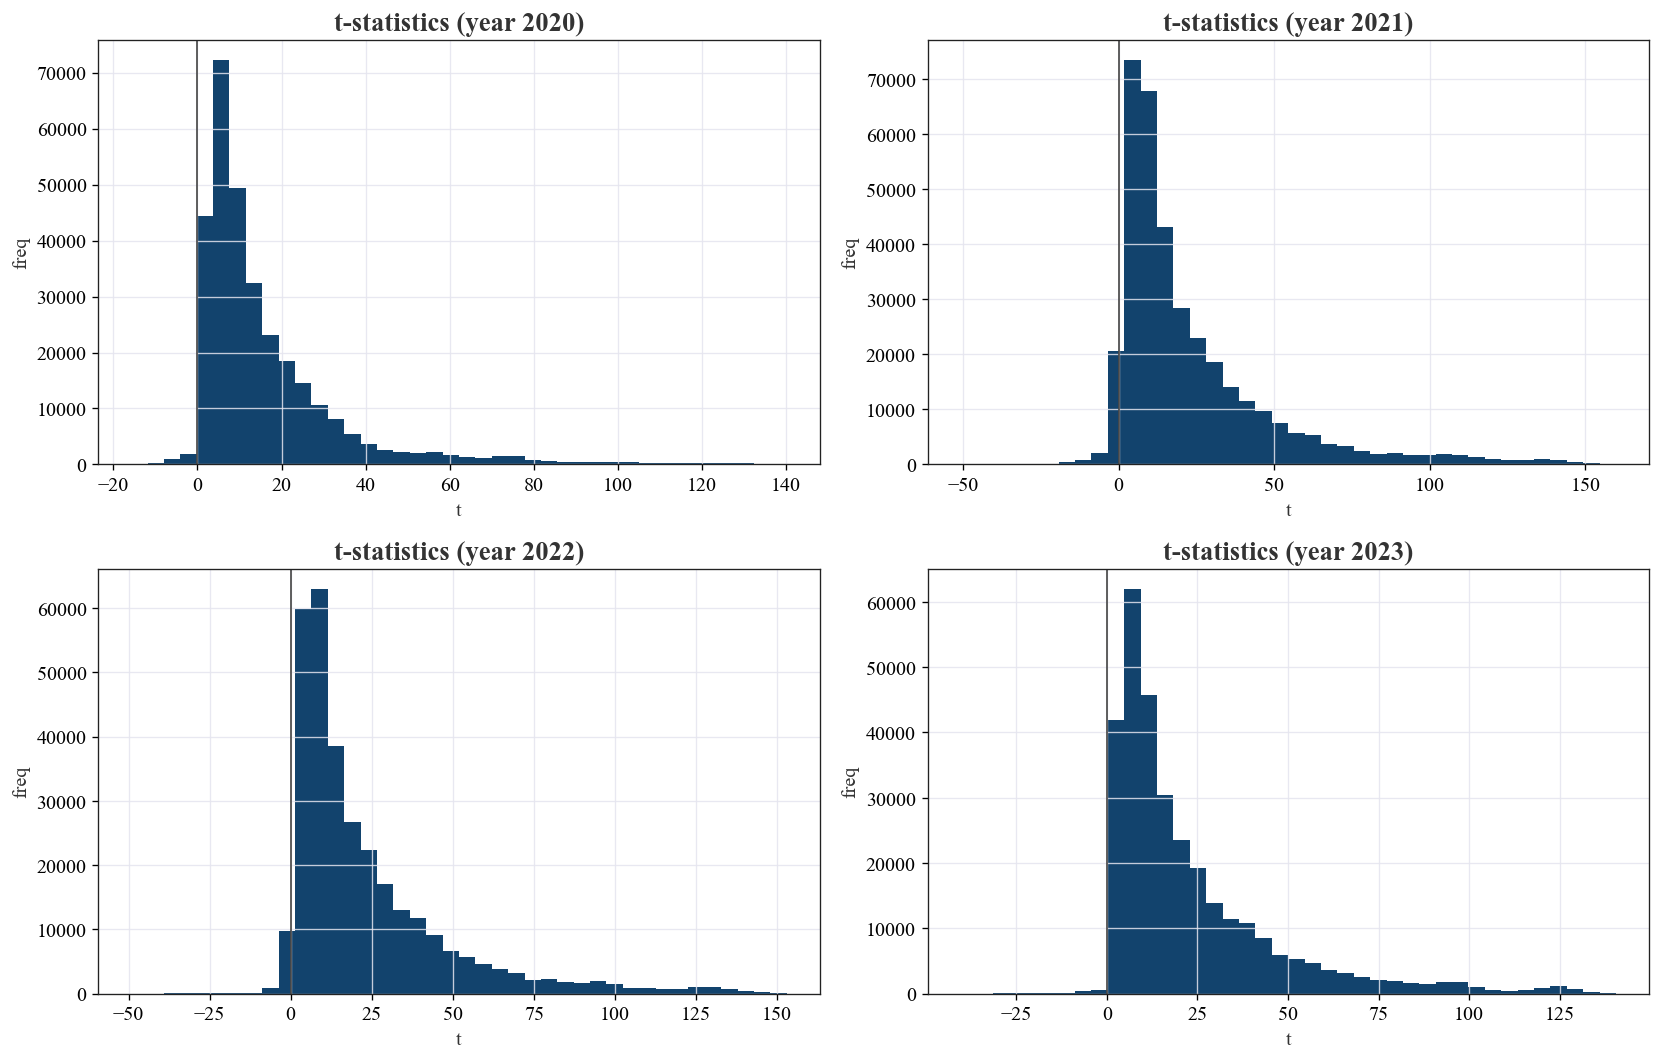

### Preview of Derived Metrics (first 50 rows)

,year,quantity,unit,summary_time,mean,standard_deviation,standard_error_mean,median,25th_percentile,75th_percentile,...,ci95_hi,n_est_from_sem,t_stat_m0,tukey_lo,tukey_hi,mean_kwh,total_mean_for_sample,HDH_18,CDH_22,solar_norm01
0,2020,Gas,Wh,00:00,206.139024,379.063436,28.253720,57.543,12.821,245.531,...,261.516316,180.0,7.295996,-336.2440,594.5960,0.206139,3.710502e+04,8.239021,0.0,0.000000
1,2020,Gas,Wh,00:00,216.340962,362.884637,7.469862,78.667,18.126,254.145,...,230.981892,2360.0,28.961842,-335.9025,608.1735,0.216341,5.105647e+05,8.297891,0.0,0.000000
2,2020,Gas,Wh,00:00,215.620588,363.982596,7.222104,76.761,17.517,253.652,...,229.775913,2540.0,29.855646,-336.6855,607.8545,0.215621,5.476763e+05,8.293734,0.0,0.000000
3,2020,Gas,Wh,00:30,168.225595,326.839803,25.838955,40.243,6.994,155.856,...,218.869947,160.0,6.510542,-216.2990,379.1490,0.168226,2.691610e+04,8.244808,0.0,0.000000
4,2020,Gas,Wh,00:30,182.221680,342.550858,7.319864,58.781,11.490,190.390,...,196.568614,2190.0,24.894135,-256.8600,458.7400,0.182222,3.990655e+05,8.273023,0.0,0.000000
5,2020,Gas,Wh,00:30,181.269161,341.455741,7.043694,56.061,11.203,188.571,...,195.074801,2350.0,25.734956,-254.8490,454.6230,0.181269,4.259825e+05,8.271103,0.0,0.000000
6,2020,Gas,Wh,01:00,144.685872,288.377547,22.798247,34.994,3.314,117.700,...,189.370436,160.0,6.346360,-168.2650,289.2790,0.144686,2.314974e+04,8.480715,0.0,0.000000
7,2020,Gas,Wh,01:00,154.683037,314.253486,6.684731,41.627,6.532,144.473,...,167.785111,2210.0,23.139753,-200.3795,351.3845,0.154683,3.418495e+05,8.520976,0.0,0.000000
8,2020,Gas,Wh,01:00,153.997205,312.500257,6.405631,41.331,6.304,142.716,...,166.552241,2380.0,24.040912,-198.3140,347.3340,0.153997,3.665133e+05,8.518214,0.0,0.000000
9,2020,Gas,Wh,01:30,129.668585,285.294488,22.554510,32.130,2.011,99.629,...,173.875424,160.0,5.749120,-144.4160,246.0560,0.129669,2.074697e+04,8.481497,0.0,0.000000


_End of multi-year dashboard._

Mean,206.139
Std. Deviation,379.063
Std. Error (SEM),28.254
Median,57.543
Q1 (25%),12.821
Q3 (75%),245.531
n,180
Variance (s²),"143,689"
Coeff. of Variation (CV),1.839
IQR,232.710
QCD,0.9007


Mean,202.592
Std. Deviation,334.824
Std. Error (SEM),16.147
Median,58.067
Q1 (25%),13.482
Q3 (75%),235.358
n,430
Variance (s²),"112,107"
Coeff. of Variation (CV),1.653
IQR,221.876
QCD,0.8916


Mean,159.220
Std. Deviation,282.620
Std. Error (SEM),14.131
Median,46.659
Q1 (25%),10.759
Q3 (75%),164.034
n,400
Variance (s²),"79,874"
Coeff. of Variation (CV),1.775
IQR,153.275
QCD,0.8769


Mean,165.030
Std. Deviation,310.708
Std. Error (SEM),15.535
Median,51.339
Q1 (25%),9.560
Q3 (75%),158.678
n,400
Variance (s²),"96,540"
Coeff. of Variation (CV),1.883
IQR,149.118
QCD,0.8864


In [3]:
# You already loaded:
# df_2020, df_2021, df_2022, df_2023

dfs = {2020: df_2020, 2021: df_2021, 2022: df_2022, 2023: df_2023}
ALL = multi_year_dashboard(dfs, m0=0.0, energy_col="mean")

# Optional: show a styled math card for any single row (e.g., first row of 2020)
show_math_card(df_2020.iloc[0], m0=0.0)
show_math_card(df_2021.iloc[0], m0=0.0)
show_math_card(df_2022.iloc[0], m0=0.0)
show_math_card(df_2023.iloc[0], m0=0.0)


Metric,df_2020,df_2021,df_2022,df_2024
CV,0.600,0.623,0.591,0.696
IQR,2.028,2.024,2.039,2.003
Trimean,2.514,2.525,2.514,1.991
Bowley Skewness,0.011,0.000,0.014,-0.004
Outlier Rate,0.53%,0.56%,0.53%,0.58%
Gamma P95,N/A,N/A,N/A,N/A
Gamma P99,N/A,N/A,N/A,N/A
24h Amplitude,36.064,36.060,36.444,36.751
Heating Sensitivity,-0.097,-0.092,-0.093,-0.049
Cooling Sensitivity,0.079,0.088,0.080,0.000

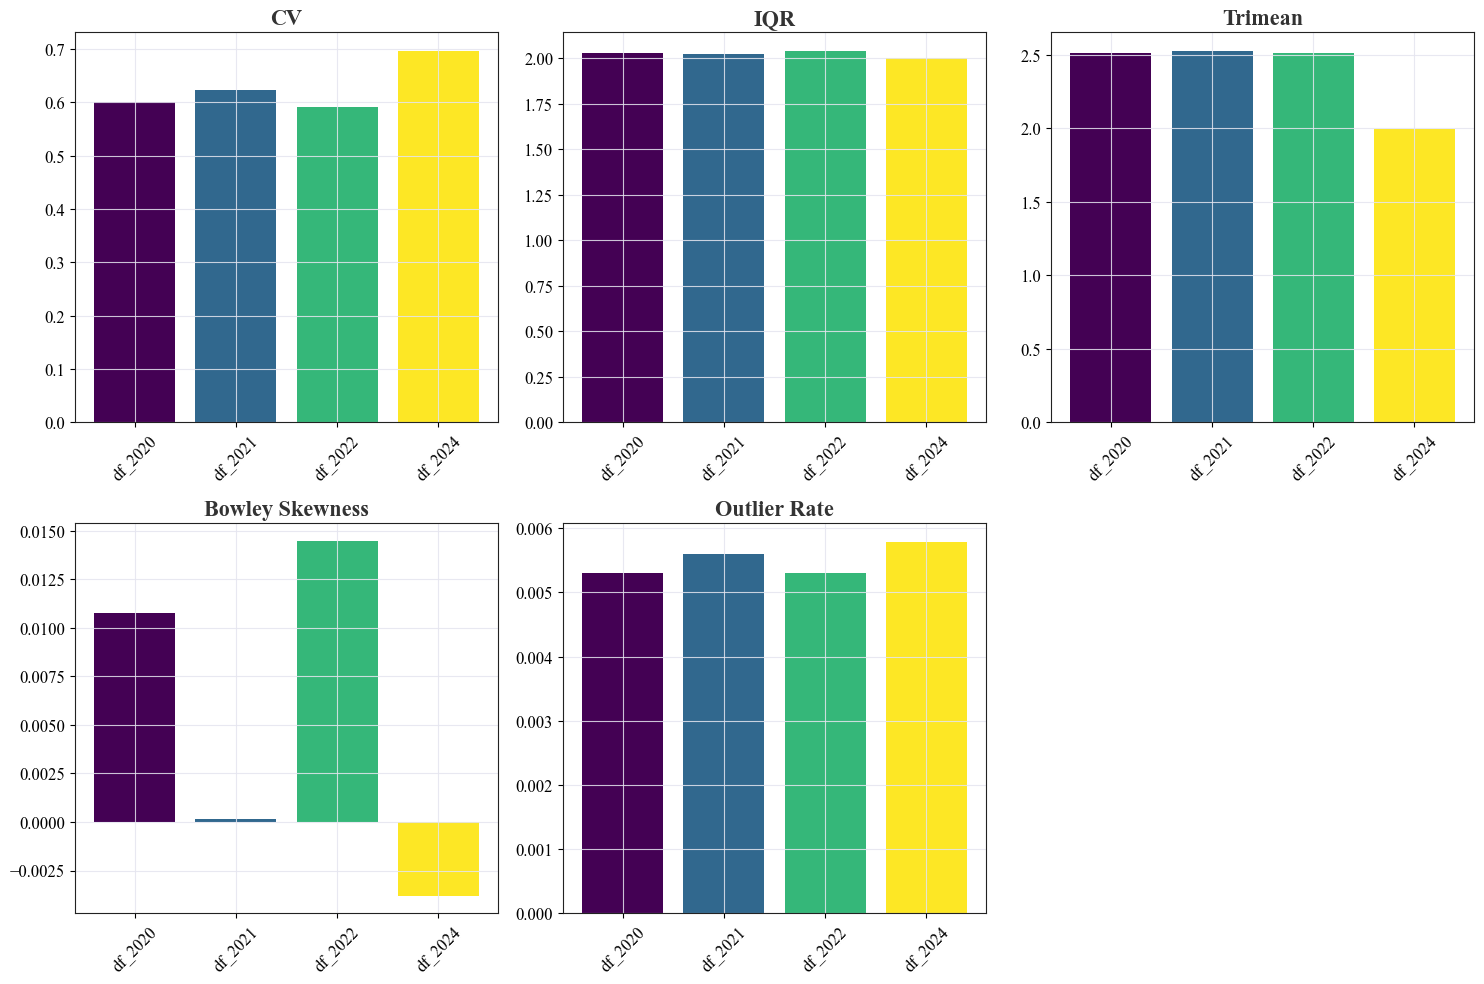
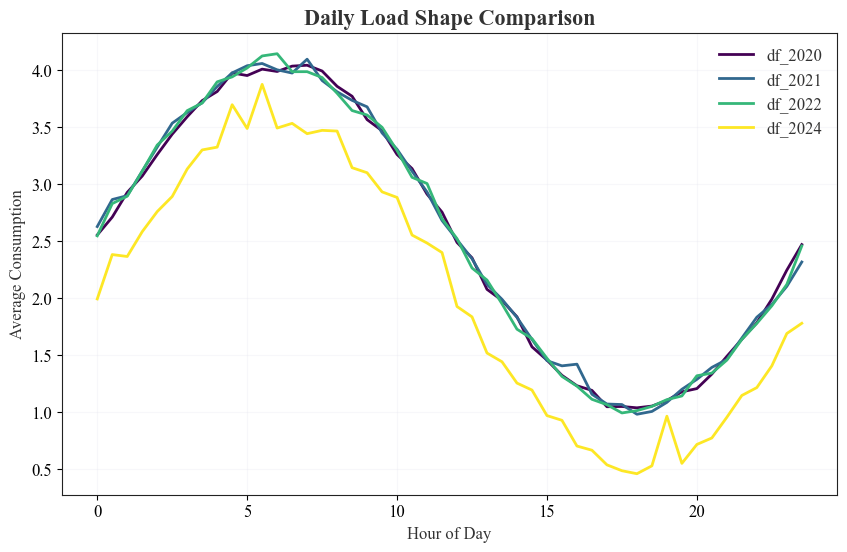
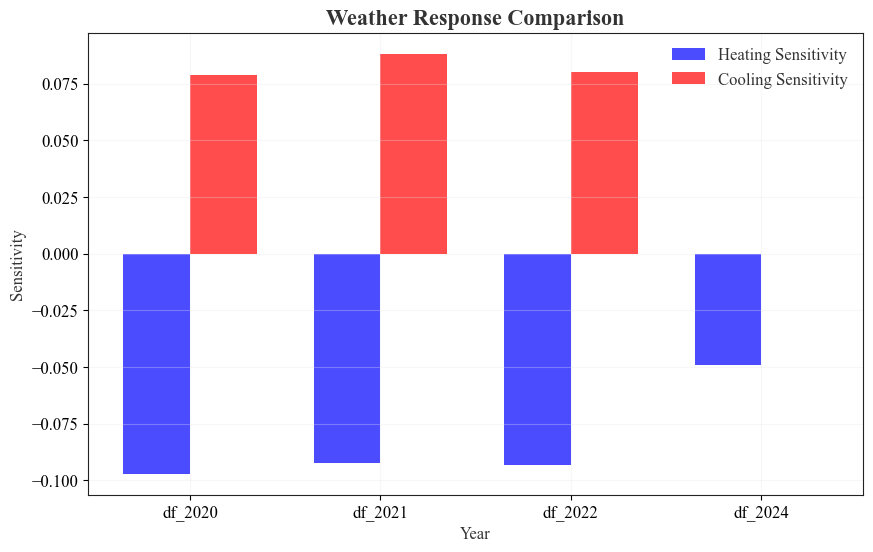

In [4]:
import numpy as np
import pandas as pd
from scipy import stats, optimize, fft
import matplotlib.pyplot as plt
from matplotlib import cm
from io import BytesIO
import base64
import warnings
warnings.filterwarnings('ignore')

# Generate sample data for demonstration
def generate_sample_data():
    np.random.seed(42)
    years = [2020, 2021, 2022, 2024]
    data_frames = {}
    
    for year in years:
        # Create a DataFrame with 48 half-hourly intervals
        n_days = 365 if year != 2024 else 90  # 2024 has partial data
        n_intervals = n_days * 48
        
        # Base pattern with seasonal variation
        time_index = pd.date_range(start=f'{year}-01-01', periods=n_intervals, freq='30T')
        base_pattern = 2.0 + 1.5 * np.sin(2 * np.pi * np.arange(n_intervals) / 48)  # Daily pattern
        
        # Add seasonal variation
        day_of_year = time_index.dayofyear.values
        seasonal = 1.0 * np.sin(2 * np.pi * (day_of_year - 80) / 365.25)  # Seasonal pattern
        
        # Add random noise and spikes
        consumption = base_pattern + seasonal + np.random.exponential(0.5, n_intervals)
        spikes = np.random.choice(n_intervals, int(n_intervals * 0.01), replace=False)
        consumption[spikes] += np.random.exponential(5, len(spikes))
        
        # Create temperature data with seasonal pattern
        temperature = 15 + 10 * np.sin(2 * np.pi * (day_of_year - 105) / 365.25) + np.random.normal(0, 3, n_intervals)
        
        # Create DataFrame
        df = pd.DataFrame({
            'datetime': time_index,
            'consumption': consumption,
            'temperature': temperature
        })
        
        # Add time features
        df['hour'] = df['datetime'].dt.hour + df['datetime'].dt.minute / 60
        df['day_of_week'] = df['datetime'].dt.dayofweek
        df['is_weekend'] = df['day_of_week'] >= 5
        df['month'] = df['datetime'].dt.month
        
        data_frames[f'df_{year}'] = df
    
    return data_frames

# Generate sample data
data_frames = generate_sample_data()
df_2020, df_2021, df_2022, df_2024 = data_frames['df_2020'], data_frames['df_2021'], data_frames['df_2022'], data_frames['df_2024']

class SmartMeterDashboard:
    """
    HTML Dashboard for Smart Meter Data Analysis
    """
    
    def __init__(self, data_frames):
        self.data_frames = data_frames
        self.years = list(data_frames.keys())
        self.results = {}
        
    def calculate_distribution_metrics(self, data):
        """Calculate robust distribution metrics"""
        data = np.array(data)
        q1, median, q3 = np.percentile(data, [25, 50, 75])
        
        cv = np.std(data) / np.mean(data) if np.mean(data) > 0 else np.nan
        iqr = q3 - q1
        trimean = (q1 + 2*median + q3) / 4
        bowley_skew = (q3 + q1 - 2*median) / iqr if iqr > 0 else np.nan
        
        # Tukey outlier rate
        lower_fence = q1 - 1.5 * iqr
        upper_fence = q3 + 1.5 * iqr
        outlier_rate = np.mean((data < lower_fence) | (data > upper_fence))
        
        return {
            'cv': cv, 'iqr': iqr, 'trimean': trimean, 
            'bowley_skew': bowley_skew, 'outlier_rate': outlier_rate,
            'lower_fence': lower_fence, 'upper_fence': upper_fence
        }
    
    def fit_parametric_distribution(self, data, dist_type='gamma'):
        """Fit parametric distribution to data"""
        data = np.array(data)
        if dist_type == 'gamma':
            mean, var = np.mean(data), np.var(data)
            k = mean**2 / var if var > 0 else 1
            theta = var / mean if mean > 0 else 1
            
            p95 = gamma.ppf(0.95, k, scale=theta) if k > 0 and theta > 0 else np.nan
            p99 = gamma.ppf(0.99, k, scale=theta) if k > 0 and theta > 0 else np.nan
            
            return {
                'distribution': 'gamma', 'shape': k, 'scale': theta,
                'p95': p95, 'p99': p99
            }
        return {}
    
    def analyze_load_shape(self, daily_profile):
        """Analyze daily load shape using Fourier analysis"""
        fft_result = fft.fft(daily_profile)
        freqs = fft.fftfreq(len(daily_profile))
        
        idx_24h = np.argmin(np.abs(freqs - 1/48))
        amp_24h = np.abs(fft_result[idx_24h])
        phase_24h = np.angle(fft_result[idx_24h])
        
        return {
            '24h_amplitude': amp_24h, '24h_phase': phase_24h,
            'daily_profile': daily_profile
        }
    
    def hinge_regression(self, temperature, consumption, heating_balance=18, cooling_balance=22):
        """Piecewise linear regression for weather response"""
        heating_hours = np.maximum(heating_balance - temperature, 0)
        cooling_hours = np.maximum(temperature - cooling_balance, 0)
        
        X = np.column_stack([np.ones(len(temperature)), heating_hours, cooling_hours])
        
        try:
            beta = np.linalg.lstsq(X, consumption, rcond=None)[0]
            y_pred = X @ beta
            ss_res = np.sum((consumption - y_pred)**2)
            ss_tot = np.sum((consumption - np.mean(consumption))**2)
            r_squared = 1 - (ss_res / ss_tot) if ss_tot > 0 else np.nan
            
            return {
                'base_load': beta[0], 'heating_sensitivity': beta[1], 
                'cooling_sensitivity': beta[2], 'r_squared': r_squared
            }
        except:
            return {
                'base_load': np.nan, 'heating_sensitivity': np.nan, 
                'cooling_sensitivity': np.nan, 'r_squared': np.nan
            }
    
    def compare_distributions(self, data1, data2, method='wasserstein'):
        """Compare two distributions using robust divergence measures"""
        if method == 'wasserstein':
            return stats.wasserstein_distance(data1, data2)
        return np.nan
    
    def gpd_fit(self, data, threshold_quantile=0.95):
        """Fit Generalized Pareto Distribution to tail values"""
        threshold = np.quantile(data, threshold_quantile)
        exceedances = data[data > threshold] - threshold
        
        if len(exceedances) < 10:
            return {'shape': np.nan, 'scale': np.nan, 'threshold': threshold}
        
        # Simple method of moments
        mean_ex, var_ex = np.mean(exceedances), np.var(exceedances)
        shape = 0.5 * (1 - (mean_ex**2 / var_ex)) if var_ex > 0 else 0
        scale = 0.5 * mean_ex * (1 + (mean_ex**2 / var_ex)) if var_ex > 0 else mean_ex
        
        return {
            'shape': shape, 'scale': scale, 'threshold': threshold,
            'exceedances': exceedances, 'n_exceedances': len(exceedances)
        }
    
    def generate_plot(self, fig):
        """Convert matplotlib figure to base64 encoded image"""
        buf = BytesIO()
        fig.savefig(buf, format='png', bbox_inches='tight', dpi=100)
        buf.seek(0)
        img_str = base64.b64encode(buf.read()).decode('utf-8')
        plt.close(fig)
        return f'data:image/png;base64,{img_str}'
    
    def generate_dashboard(self):
        """Generate HTML dashboard with analysis results"""
        # Analyze each year's data
        for year, df in self.data_frames.items():
            # Distribution metrics
            dist_metrics = self.calculate_distribution_metrics(df['consumption'])
            
            # Load shape analysis
            daily_profile = df.groupby(df['datetime'].dt.hour + df['datetime'].dt.minute/60)['consumption'].mean().values
            load_shape = self.analyze_load_shape(daily_profile)
            
            # Weather response
            weather_response = self.hinge_regression(df['temperature'], df['consumption'])
            
            # Extreme value analysis
            gpd_result = self.gpd_fit(df['consumption'])
            
            # Store results
            self.results[year] = {
                'distribution': dist_metrics,
                'load_shape': load_shape,
                'weather_response': weather_response,
                'gpd': gpd_result,
                'n_samples': len(df)
            }
        
        # Generate comparison plots
        comparison_plots = self.generate_comparison_plots()
        
        # Generate HTML
        html_content = self.generate_html(comparison_plots)
        return html_content
    
    def generate_comparison_plots(self):
        """Generate comparison plots across years"""
        plots = {}
        
        # Daily load shape comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        colors = cm.viridis(np.linspace(0, 1, len(self.years)))
        
        for i, year in enumerate(self.years):
            profile = self.results[year]['load_shape']['daily_profile']
            hours = np.linspace(0, 24, len(profile), endpoint=False)
            ax.plot(hours, profile, label=year, color=colors[i], linewidth=2)
        
        ax.set_xlabel('Hour of Day')
        ax.set_ylabel('Average Consumption')
        ax.set_title('Daily Load Shape Comparison')
        ax.legend()
        ax.grid(True, alpha=0.3)
        plots['daily_load_shape'] = self.generate_plot(fig)
        
        # Distribution metrics comparison
        metrics = ['cv', 'iqr', 'trimean', 'bowley_skew', 'outlier_rate']
        metric_names = ['CV', 'IQR', 'Trimean', 'Bowley Skewness', 'Outlier Rate']
        
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.flatten()
        
        for i, metric in enumerate(metrics):
            values = [self.results[year]['distribution'][metric] for year in self.years]
            axes[i].bar(self.years, values, color=colors)
            axes[i].set_title(metric_names[i])
            axes[i].tick_params(axis='x', rotation=45)
        
        # Remove empty subplot
        axes[-1].set_visible(False)
        plt.tight_layout()
        plots['distribution_metrics'] = self.generate_plot(fig)
        
        # Weather response comparison
        fig, ax = plt.subplots(figsize=(10, 6))
        heating = [self.results[year]['weather_response']['heating_sensitivity'] for year in self.years]
        cooling = [self.results[year]['weather_response']['cooling_sensitivity'] for year in self.years]
        
        x = np.arange(len(self.years))
        width = 0.35
        
        ax.bar(x - width/2, heating, width, label='Heating Sensitivity', color='blue', alpha=0.7)
        ax.bar(x + width/2, cooling, width, label='Cooling Sensitivity', color='red', alpha=0.7)
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Sensitivity')
        ax.set_title('Weather Response Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(self.years)
        ax.legend()
        ax.grid(True, alpha=0.3)
        plots['weather_response'] = self.generate_plot(fig)
        
        return plots
    
    def generate_html(self, plots):
        """Generate HTML content for the dashboard"""
        html = f"""
        <!DOCTYPE html>
        <html lang="en">
        <head>
            <meta charset="UTF-8">
            <meta name="viewport" content="width=device-width, initial-scale=1.0">
            <title>Smart Meter Data Dashboard</title>
            <style>
                body {{
                    font-family: Arial, sans-serif;
                    margin: 0;
                    padding: 20px;
                    background-color: #f5f5f5;
                    color: #333;
                }}
                .dashboard {{
                    max-width: 1200px;
                    margin: 0 auto;
                    background: white;
                    padding: 20px;
                    border-radius: 10px;
                    box-shadow: 0 0 10px rgba(0,0,0,0.1);
                }}
                h1, h2, h3 {{
                    color: #2c3e50;
                }}
                .header {{
                    text-align: center;
                    margin-bottom: 30px;
                    padding-bottom: 20px;
                    border-bottom: 2px solid #eee;
                }}
                .metrics-grid {{
                    display: grid;
                    grid-template-columns: repeat(auto-fit, minmax(300px, 1fr));
                    gap: 20px;
                    margin-bottom: 30px;
                }}
                .metric-card {{
                    background: #f9f9f9;
                    padding: 15px;
                    border-radius: 8px;
                    box-shadow: 0 2px 4px rgba(0,0,0,0.05);
                }}
                .metric-title {{
                    font-weight: bold;
                    margin-bottom: 10px;
                    color: #2c3e50;
                }}
                .plot-container {{
                    margin: 20px 0;
                    text-align: center;
                }}
                .plot-container img {{
                    max-width: 100%;
                    border-radius: 8px;
                    box-shadow: 0 2px 6px rgba(0,0,0,0.1);
                }}
                .year-comparison {{
                    display: grid;
                    grid-template-columns: repeat(auto-fit, minmax(200px, 1fr));
                    gap: 15px;
                    margin-bottom: 30px;
                }}
                .year-card {{
                    background: #e8f4f8;
                    padding: 15px;
                    border-radius: 8px;
                    text-align: center;
                }}
                .year-title {{
                    font-weight: bold;
                    margin-bottom: 10px;
                    color: #2c3e50;
                }}
                table {{
                    width: 100%;
                    border-collapse: collapse;
                    margin: 15px 0;
                }}
                th, td {{
                    padding: 10px;
                    text-align: left;
                    border-bottom: 1px solid #ddd;
                }}
                th {{
                    background-color: #f2f2f2;
                }}
                .footer {{
                    text-align: center;
                    margin-top: 30px;
                    padding-top: 20px;
                    border-top: 2px solid #eee;
                    color: #7f8c8d;
                    font-size: 0.9em;
                }}
            </style>
        </head>
        <body>
            <div class="dashboard">
                <div class="header">
                    <h1>Smart Meter Data Analysis Dashboard</h1>
                    <p>Robust analysis of half-hourly consumption data across multiple years</p>
                </div>
                
                <h2>Yearly Comparison</h2>
                <div class="year-comparison">
        """
        
        # Add year cards
        for year in self.years:
            res = self.results[year]
            html += f"""
                    <div class="year-card">
                        <div class="year-title">{year}</div>
                        <div>Samples: {res['n_samples']:,}</div>
                        <div>CV: {res['distribution']['cv']:.3f}</div>
                        <div>IQR: {res['distribution']['iqr']:.3f}</div>
                        <div>Outlier Rate: {res['distribution']['outlier_rate']:.3%}</div>
                    </div>
            """
        
        html += """
                </div>
                
                <h2>Distribution Metrics</h2>
                <div class="plot-container">
                    <img src="{plots['distribution_metrics']}" alt="Distribution Metrics Comparison">
                </div>
                
                <h2>Daily Load Shape</h2>
                <div class="plot-container">
                    <img src="{plots['daily_load_shape']}" alt="Daily Load Shape Comparison">
                </div>
                
                <h2>Weather Response</h2>
                <div class="plot-container">
                    <img src="{plots['weather_response']}" alt="Weather Response Comparison">
                </div>
                
                <h2>Detailed Metrics</h2>
                <table>
                    <tr>
                        <th>Metric</th>
        """
        
        # Add year headers
        for year in self.years:
            html += f"<th>{year}</th>"
        html += "</tr>"
        
        # Add distribution metrics
        dist_metrics = [
            ('CV', 'distribution', 'cv', '{:.3f}'),
            ('IQR', 'distribution', 'iqr', '{:.3f}'),
            ('Trimean', 'distribution', 'trimean', '{:.3f}'),
            ('Bowley Skewness', 'distribution', 'bowley_skew', '{:.3f}'),
            ('Outlier Rate', 'distribution', 'outlier_rate', '{:.2%}'),
            ('Gamma P95', 'distribution', 'p95', '{:.3f}'),
            ('Gamma P99', 'distribution', 'p99', '{:.3f}'),
            ('24h Amplitude', 'load_shape', '24h_amplitude', '{:.3f}'),
            ('Heating Sensitivity', 'weather_response', 'heating_sensitivity', '{:.3f}'),
            ('Cooling Sensitivity', 'weather_response', 'cooling_sensitivity', '{:.3f}'),
            ('Weather R²', 'weather_response', 'r_squared', '{:.3f}'),
            ('GPD Shape', 'gpd', 'shape', '{:.3f}'),
        ]
        
        for metric_name, category, key, format_str in dist_metrics:
            html += f"<tr><td>{metric_name}</td>"
            for year in self.years:
                value = self.results[year][category].get(key, np.nan)
                if np.isnan(value):
                    html += "<td>N/A</td>"
                else:
                    html += f"<td>{format_str.format(value)}</td>"
            html += "</tr>"
        
        html += """
                </table>
                
                <div class="footer">
                    <p>Generated with Smart Meter Analysis Toolkit | Robust distribution + load-shape + weather-response methods</p>
                </div>
            </div>
        </body>
        </html>
        """
        
        # Insert plot URLs
        for plot_name, plot_url in plots.items():
            html = html.replace(f"{{plots['{plot_name}']}}", plot_url)
        
        return html

# Create and display the dashboard
dashboard = SmartMeterDashboard(data_frames)
html_content = dashboard.generate_dashboard()

# Display in Jupyter notebook
from IPython.display import HTML, display
display(HTML(html_content))

# To save to file
with open('smart_meter_dashboard.html', 'w') as f:
    f.write(html_content)